In [1]:
!ls bearing_fatigue_dataset/

AccB_1_1.pickle  AccB_2_1.pickle  AccB_3_1.pickle
AccB_1_2.pickle  AccB_2_2.pickle  AccB_3_2.pickle
AccB_1_3.pickle  AccB_2_3.pickle  AccB_3_3.pickle
AccB_1_4.pickle  AccB_2_4.pickle  inspect_preproc.ipynb
AccB_1_5.pickle  AccB_2_5.pickle  phm-ieee-2012-data-challenge-dataset
AccB_1_6.pickle  AccB_2_6.pickle  preproc_stage_1.py
AccB_1_7.pickle  AccB_2_7.pickle


# TODO:
Read this: [Adversarial Discriminative Learning](http://openaccess.thecvf.com/content_cvpr_2017/papers/Tzeng_Adversarial_Discriminative_Domain_CVPR_2017_paper.pdf)
![image](img/AdversarialDiscriminativeDomainAdaptation.png)

## Adversarial learning on the FEMTO accelerated fatigue bearing dataset
The dataset is associated with a challenge for the PHM conference on 2012.
The motivation of this work is to investigate if and when adversarial learning on raw time-series performs well. The hypotheses of this work are the following:

* **Dilated DenseNets** are flexible enough to work with raw time-series (this is not an established fact in SHM applications)
* Adversarial learning can be used to normalize implicitly for **domain shifts** without manual intervention. 

The following need to be performed:
* Preprocessing (making the dataset appropriate for training with the adversarial densenet - domain labels etc)
* Train/test splitting for the raw accelerometer time-series
* write the optimization loop
* run prelim. experiments - hopefully something will fit. 
* write code for performing 1-vs-rest experiments to test generalization.

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
#from tensorflow.math import confusion_matrix

In [3]:
tf.__version__

'2.1.0'

In [4]:
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [5]:
def calc_receptive_field(Nd, Nf, conv_type = "causal"):
    "returns the number of input taps each layer in a dilated caysal conv stack sees."
    if conv_type == "causal":
        corr = [0]+[1]*(len(Nd)-1)#correction for double counted neurons.
    
    return np.cumsum([(nf_) * (nd_) - (nd_-1) - c for nf_, nd_ ,c in zip(Nf, Nd, corr)])  #- (len(Nd)) + 1

calc_receptive_field([2**n for n in range(10)],[2]*10)
calc_receptive_field([3**n for n in range(10)],[3]*10)


array([    3,     9,    27,    81,   243,   729,  2187,  6561, 19683,
       59049])

In [6]:
from src.util import plot_confusion_matrix
from src.experiments_utils import *

ndn = 5
nkernel = 4;
ndn2 = 6
ndomain = 17;

experiment_parametrization = {
    'dilation_rates_dn1': [1,4,8,16,32,64,128,256,512,8,16,32,64,128,512][0:ndn],#,4,8,16,32],
    'kernel_sizes_dn1' :  [nkernel] * ndn,#,5,5],
    'nfilters_dn1' :  [50]*ndn,
    'dilation_rates_dn2' : [2]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#

model_json['classifier']['network_layers'][0]['params']['units'] = 640
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"][0]['params']["dropout_after_composite"] = 0.1
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
model_json['inputs'][0]['shape'] = (2559,2)
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = ndomain
# Make the model act as a regressor:
model_json['classifier']['network_layers'][-1]['params']['units'] = 1
Nf = model_json['densenet_1d']['network_layers'][0]['params']['kernel_sizes']
Nd = model_json['densenet_1d']['network_layers'][0]['params']['dilation_rates']
model_json['densenet_1d']['network_layers']
single_DN_stack_rf = calc_receptive_field(Nd,Nf)
single_DN_stack_rf * len(Nf)

array([ 20,  80, 200, 440, 920])

In [7]:

model = make_model(model_json)
get_global_pool_layer = lambda mm : mm.get_layer([l.name for l in mm.layers if 'global_average' in l.name][0])

from src.dilated_densenet_adversarial import GradReverse

# The two different learned embeddings are used for two different tasks: 
# 1) predict d and fail predict y
# 2) predict y and fail to predict d
#
# Hopefully what I should observe is that the network learns to output
# two separate embeddings at the same time.
pooling_output_layer = get_global_pool_layer = get_global_pool_layer(model);

Emb_PyNd = keras.Sequential([keras.layers.Dense(100) , keras.layers.Dense(50,activation = "relu")], name = "PyNd")(pooling_output_layer.output)
Emb_PdNy = keras.Sequential([keras.layers.Dense(100) , keras.layers.Dense(50,activation = "relu")],name = "PdNy")(pooling_output_layer.output)
ndomain = 17;
PyNd_y_predictor = keras.Sequential([Dense(50, activation = 'relu'), Dense(50, activation = 'relu'), Dense(1)],name = "PyNd_y_predictor");
PyNd_d_critic = keras.Sequential([GradReverse(), Dense(50, activation = 'relu'), Dense(50, activation = 'relu'), Dense(ndomain)],name = "PyNd_d_critic");

PdNy_d_predictor = keras.Sequential([Dense(50, activation = 'relu'), Dense(50, activation = 'relu'), Dense(ndomain)],name = "PdNy_d_predictor");
PdNy_y_critic = keras.Sequential([GradReverse(),Dense(50, activation = 'relu'), Dense(50, activation = 'relu'), Dense(1)],name = "PdNy_y_critic");

disc_adv = keras.Model(inputs = model.inputs, outputs = [
    PyNd_y_predictor(Emb_PyNd),PyNd_d_critic(Emb_PyNd),PdNy_y_critic(Emb_PdNy),PdNy_d_predictor(Emb_PdNy)])

model = disc_adv;


Tensor("DN_DN1_ConcatOut/Identity:0", shape=(None, 2559, 800), dtype=float32)


In [8]:
disc_adv.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 2559, 2)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 2559, 50)     150         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 2559, 50)     12600       DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 2559, 50)     12600       DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]           

In [9]:
#model.summary()
inspect_ddout = Model(inputs = model.get_layer("timeseries_input").input,outputs = model.get_layer("DN_DN1_Out").output)


In [10]:
import pandas as pd
import matplotlib.pyplot as pplot
import numpy as np


In [11]:
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

In [12]:
!ls bearing_fatigue_dataset/phm-ieee-2012-data-challenge-dataset/Learning_set/

Bearing1_1  Bearing1_2	Bearing2_1  Bearing2_2	Bearing3_1  Bearing3_2


In [13]:
def load_bearings_dataset(all_files = all_files):
    fnames = all_files
    exp_ids_tot = [];
    yrem_tot = [];
    sensor_values_tot = []

    for kk,fname in enumerate(fnames):
        p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
        p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
        sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
        sens_val = np.dstack([v[1] for v in sensors.values])
        sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
        print(sensor_values.shape)
        
        yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
        yrem = np.abs(yrem - np.max(yrem))

        exp_id = np.hstack([kk for v in range(yrem.shape[0])])

        sensor_values_tot.append(sensor_values)
        exp_ids_tot.append(exp_id);
        yrem_tot.append(yrem)

        print(kk)

    yrem_tot = np.vstack(yrem_tot).flatten()
    eid = np.hstack(exp_ids_tot).flatten()
    X = np.vstack(sensor_values_tot)
    return yrem_tot, eid, X
yrem_s_raw, eid, X = load_bearings_dataset()


(172, 2559, 2)
0
(1502, 2559, 2)
1
(1637, 2559, 2)
2
(515, 2559, 2)
3
(871, 2559, 2)
4
(1802, 2559, 2)
5
(2302, 2559, 2)
6
(1202, 2559, 2)
7
(1139, 2559, 2)
8
(2002, 2559, 2)
9
(572, 2559, 2)
10
(352, 2559, 2)
11
(797, 2559, 2)
12
(911, 2559, 2)
13
(612, 2559, 2)
14
(2803, 2559, 2)
15
(2302, 2559, 2)
16


In [15]:
yrem = [];
for ee in np.unique(eid):
    yelapsed_ = np.cumsum(yrem_s_raw[eid == ee])
    yrem_ = np.max(yelapsed_) - yelapsed_;
    yrem.append(yrem_)
yrem = np.hstack(yrem)

## Taking data from the end
In order to 

* ballance the classes
* have time-series with more features related to failure

the time-series is truncated closer to the failure of the specimens.

In [16]:
if False:
    # trim the dataset closer to failure for ballancing 
    pplot.plot(yrem[yrem<500000],'.')
    yrem,yrem_s_raw, eid, X = [yrem[yrem<500000],yrem_s_raw[yrem<500000], eid[yrem<500000], X[yrem<500000]]

## Train-test splitting:

In [17]:
eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

In [18]:
from sklearn.model_selection import train_test_split
yrem_norm = yrem / np.std(yrem);
x_train, x_test, y_train, y_test, d_train, d_test = train_test_split(X, yrem_norm, eid_oh, stratify = eid_oh)

In [19]:
X.shape

(21493, 2559, 2)

In [71]:
from ipywidgets import IntSlider, interact
@interact(ii_ = IntSlider(min = 0,max = X.shape[0], step = 100))
def ii(ii_):
    pplot.plot(X[ii_])
    
    pplot.ylim([-5,5])
    print(yrem[ii_], eid[ii_])

interactive(children=(IntSlider(value=0, description='ii_', max=21493, step=100), Output()), _dom_classes=('wi…

In [20]:
# split_files by operating conditions:
operating_conditions = ['1','2','3'];
files_per_condition = {oc : [(f,idx, np.max(yrem_s_raw[eid == idx])) for idx,f in enumerate(all_files) if f[5] == oc] for oc in operating_conditions}
files_per_condition

{'1': [('AccB_1_7.pickle', 1, 15010.0),
  ('AccB_1_2.pickle', 4, 8700.0),
  ('AccB_1_3.pickle', 5, 18010.002),
  ('AccB_1_5.pickle', 6, 23010.0),
  ('AccB_1_4.pickle', 8, 11380.002),
  ('AccB_1_1.pickle', 15, 28072.203),
  ('AccB_1_6.pickle', 16, 23010.0)],
 '2': [('AccB_2_7.pickle', 0, 1710.0),
  ('AccB_2_3.pickle', 7, 12010.0),
  ('AccB_2_5.pickle', 9, 20010.0),
  ('AccB_2_6.pickle', 10, 5710.0),
  ('AccB_2_2.pickle', 12, 7960.0),
  ('AccB_2_1.pickle', 13, 9100.0),
  ('AccB_2_4.pickle', 14, 6110.0)],
 '3': [('AccB_3_2.pickle', 2, 16360.0),
  ('AccB_3_1.pickle', 3, 5140.0),
  ('AccB_3_3.pickle', 11, 3510.0)]}

## Manual selection of some tests for training, considering the cycles to failure.
 In order to be able to generalize, it is better if the strong test set comprises of tests that
 fail in the range of the training set. The sellection goes as follows:
 
 |condition |set|experiment indices|total time to failure|exp_strings|
 |-- | -- | -- | -- |--|
 |1| training | (4, 6, 8, 15)| (8700, 23010, 11380, 28072) |... |
 |2|training|(9, 10, 0,7)|(20010,5710,1710,12010)|...|
 |3|training|(2,11)|(16360,3510) | ...|
 |1|validation| (1, 5, 16) | (15010, 18010, 23010) | ...|
 |2|validation|(12,13,14)|(7960,9100,6110)|...|
 |3|validation|(3) | (5140)|...|
 

In [26]:
## TODO: Make a second "domain" and corresponding embedding for the load.

#training_set_mask = 
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_data_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_data_target  = [1,5,16,  12,13,14,  3]

X_source_experiments = X[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_source]]
X_target_experiments = X[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]

#for ct, tdi in zip(conds_flag_train, inds_data_train):
#    training_data 

In [95]:
#pplot.plot(model.get_layer("DN_DN1_C1D").get_weights()[0][0])
#c1 = model.get_layer("DN_DN1_C1D")
#model.summary()
#c2 = model.get_layer("global_average_pooling1d")
#insp_inp = Input(shape = (400,2))
#c1(insp_inp)
#inspect_2 = keras.Model(inputs = c1(insp_inp), outputs = c2.output)

## Training


In [96]:
#feature_extractor = keras.Model(inputs = model.inputs, outputs = get_global_pool_layer(model).output)

In [97]:
np.argmax(d_train,1)

array([ 8, 16, 13, ...,  9,  9,  5])

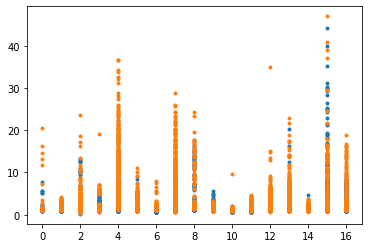

In [98]:
#pplot.plot(np.argmax(d_train,0),np.std(x_train,0))
pplot.plot(np.argmax(d_train,1),np.max(x_train,1),'.')

In [99]:
#["P%sN%s"%(a,b,c1) for a,b,c1 in [["d","y","_d_predictor"],["d","y","_d_predictor"],["y","d","_y_predictor","_d_critic"]]*2]


In [100]:
#tf.executing_eagerly()

In [14]:

epochs = 50; #training_parameters["nepochs"]
batchsize =40;
if (tf.__version__ == '2.1.0'):
    confusion_matrix = tf.compat.v1.math.confusion_matrix
else:
    from tensorflow.math import confusion_matrix
    
import tensorflow.keras as keras
from tensorflow.keras import layers 

LRATE_MIN = 0.001;
LRATE_MAX = 0.005;
BURNIN_EPOCHS = 5;

closs = 0.1

es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);



class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        top3acc, cmatrix_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        self.top3acc_strong.append(top3acc)

class plot_PCA(tf.keras.callbacks.Callback):
    def __init__(self):
        None
    def on_epoch_end(self,epoch,logs = None):
        a,b = get_vv_vals()
        pp = PCA(n_components=2).fit_transform((a - np.mean(a,0)) /np.std(a))
        pplot.scatter(pp[:,0], pp[:,1],c = b)
        pplot.show()
        #top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        
class plot_fit(tf.keras.callbacks.Callback):
    def __init__(self):
        None
        
    def on_epoch_end(self,epoch, logs = None):
        if (epoch+1) % 2 == 0:
            yhat = model.predict(x_train, batch_size = batchsize)
            pplot.cla()
            pplot.plot(yhat[2], y_train,'.')
            pplot.show()
        
class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            lrate = de * self.learning_rate
            if lrate < LRATE_MIN:
                model_opt.learning_rate = LRATE_MIN
            else:
                model_opt.learning_rate = de * self.learning_rate

def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)


def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()


loss_fcn = {"PdNy_y_critic" :lambda y,yhat : tf.reduce_mean(tf.abs(y-yhat)), #*1/(0.1+abs(y)*1.5)),
            "PdNy_d_predictor" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
            "PyNd_y_predictor" :lambda y,yhat : tf.reduce_mean(tf.abs(y-yhat)), #*1/(0.1+abs(y)*1.5)),
            "PyNd_d_critic" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
           }


loss_weight_dict = {k:v for k,v in zip(["PdNy_y_critic","PdNy_d_predictor","PyNd_y_predictor","PyNd_d_critic"],[closs,1.,1.,closs])}

# GOAL: Maximize the loss of the domain critic while maximizing the actual predictor.

# useful discriminator:
model.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_weight_dict)

train_in, train_out = [{"timeseries_input": x_train},{"PdNy_y_critic":y_train,
                                                     "PdNy_d_predictor" : d_train,
                                                     "PyNd_d_critic":d_train,
                                                     "PyNd_y_predictor" : y_train}]

test_in, test_out= [{"timeseries_input": x_test},{"PdNy_y_critic":y_test,
                                                     "PdNy_d_predictor" : d_test,
                                                     "PyNd_d_critic":d_test,
                                                     "PyNd_y_predictor" : y_test}]

#test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]
burnin = BurnIn(burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
history_d = model.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, burnin, plot_fit()])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])




NameError: name 'x_train' is not defined

In [ ]:
yhat = model.predict(x_train, batch_size = 100)
pplot.cla()
pplot.plot(yhat[2], y_train,'.')
pplot.show()

In [151]:
insp_model_PdNy = Model(model.input,outputs = model.get_layer("PdNy").output)
insp_model_PyNd = Model(model.input,outputs = model.get_layer("PyNd").output)



In [152]:
Y_PyNd = insp_model_PdNy.predict(x_train, batch_size=100)
Y_PdNy = insp_model_PyNd.predict(x_train, batch_size=100)

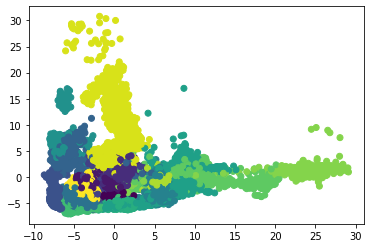

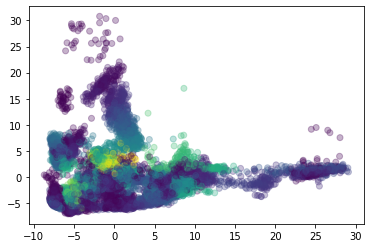

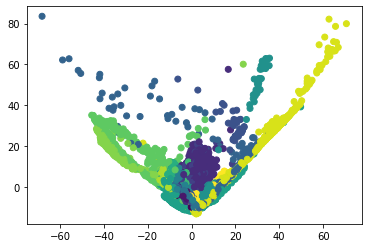

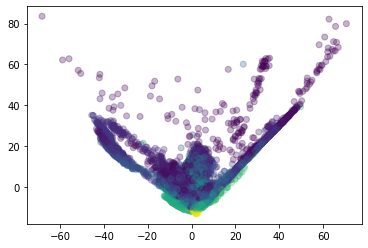

In [165]:
from sklearn.decomposition import PCA
y1 = PCA(n_components=3).fit_transform(Y_PyNd[:,:]**0.5) 
y2 = PCA(n_components=3).fit_transform(Y_PdNy[:,:]**0.5) 
#pplot.plot(y1[:,0], y_train,'.')
pplot.scatter(y1[:,0], y1[:,1], c = np.argmax(d_train,1))

pplot.show()
pplot.scatter(y1[:,0], y1[:,1], c = y_train**0.5, alpha = 0.3)
pplot.show()
pplot.scatter(y2[:,0], y2[:,1], c = np.argmax(d_train,1))
pplot.show()
pplot.scatter(y2[:,0], y2[:,1], c = y_train**0.5, alpha = 0.3)

#pplot.plot(y_train)


In [143]:

import datetime
d = datetime.datetime.now()
closs = 0;
folder = d.strftime("{0:s}_%d-%m-%y_%T_closs{1:2.3f}".format("Dilated_DenseNet",closs))

write_folder = os.path.join(os.path.curdir,"saved_models", folder);

os.mkdir(write_folder)
model.save_weights(os.path.join(write_folder, "weights.bin"))
with open(os.path.join(write_folder, "model_spec.json"),'w') as f:
    f.write(json.dumps(model_json, indent = 4))
#!mkdir saved_moels
#model.save_weights()


In [147]:
!tree saved_models/

saved_models/
└── Dilated_DenseNet_05-03-20_18:04:51_closs0.000
    ├── checkpoint
    ├── model_spec.json
    ├── weights.bin.data-00000-of-00002
    ├── weights.bin.data-00001-of-00002
    └── weights.bin.index

1 directory, 5 files


'./saved_models/Dilated_DenseNet_05-03-20_18:00:07_closs0.000/model_spec.json'

In [133]:
!ls saved_models/Dilated_DenseNet_05-03-20_17\:55\:33_closs0.000/

checkpoint			 weights.bin.data-00001-of-00002
weights.bin.data-00000-of-00002  weights.bin.index


In [128]:
#import json
#json.dumps(model_json,%precision)
#help(json.dumps)
json.dumps(model_json, indent = 4)


'{\n    "inputs": [\n        {\n            "type": "timeseries",\n            "help_string": "(required) the timeseries input for the layer.",\n            "id": "timeseries_input",\n            "shape": [\n                2559,\n                2\n            ]\n        }\n    ],\n    "densenet_1d": {\n        "network_layers": [\n            {\n                "type": "densenet_block",\n                "id": "DN1",\n                "help_string": "Parametrization for a `densenet_block`",\n                "params": {\n                    "filters": [\n                        50,\n                        50,\n                        50,\n                        50\n                    ],\n                    "dilation_rates": [\n                        2,\n                        4,\n                        8,\n                        16\n                    ],\n                    "kernel_sizes": [\n                        3,\n                        3,\n                        3,\n 

In [ ]:
pplot.plot(history_d.history['loss'])
pplot.plot(history_d.history['val_loss'])

In [125]:
#X[:,0]
import scipy
@interact(ii = IntSlider(min = 0 , max = 2000),ii2 = IntSlider(min = 0 , max = 2000), ee = IntSlider(min = 0, max = 16), nperseg = IntSlider(min = 64, max = 512))
def aa_(ii,ii2,ee,nperseg):
    x = X[eid == ee];
    print(len(x))
    #scipy.signal.fft(X[:,0])
    if ii2 > len(x): ii2 = len(x)-1
    if ii > len(x): ii = len(x)-1
    s1 = np.abs(scipy.signal.stft(x[ii][:,1],nperseg = nperseg)[2])
    s2 = np.abs(scipy.signal.stft(x[ii2][:,1],nperseg = nperseg)[2])
    pplot.pcolor(np.hstack([s1,s2]))
        

interactive(children=(IntSlider(value=0, description='ii', max=2000), IntSlider(value=0, description='ii2', ma…

In [145]:
all_files

['AccB_2_7.pickle',
 'AccB_1_7.pickle',
 'AccB_3_2.pickle',
 'AccB_3_1.pickle',
 'AccB_1_2.pickle',
 'AccB_1_3.pickle',
 'AccB_1_5.pickle',
 'AccB_2_3.pickle',
 'AccB_1_4.pickle',
 'AccB_2_5.pickle',
 'AccB_2_6.pickle',
 'AccB_3_3.pickle',
 'AccB_2_2.pickle',
 'AccB_2_1.pickle',
 'AccB_2_4.pickle',
 'AccB_1_1.pickle',
 'AccB_1_6.pickle']

In [150]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "get_ipython().system('ls bearing_fatigue_dataset/')",
  'import tensorflow as tf\n#tf.enable_eager_execution()\nimport tensorflow.keras as keras\nimport numpy as np\nimport matplotlib.pyplot as pplot\nfrom tensorflow.keras import Model\nfrom tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout\n\nimport os\n\nfrom tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsess = InteractiveSession(config=config)\n#tf.keras.backend.set_session(sess)\n#from tensorflow.math import confusion_matrix',
  'tf.__version__',
  'from src.dilated_

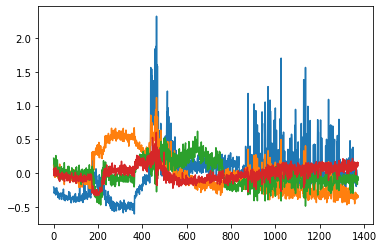

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
y = pca.fit_transform(np.vstack([np.mean(z0,1),np.mean(z1,1)]))
pplot.plot(y)

In [37]:
del z0,z1
z0 = inspect_ddout.predict(X[eid == 1],batch_size = 20)
z1 = inspect_ddout.predict(X[eid == 5], batch_size = 20)

MemoryError: Unable to allocate array with shape (1802, 2559, 400) and data type float32

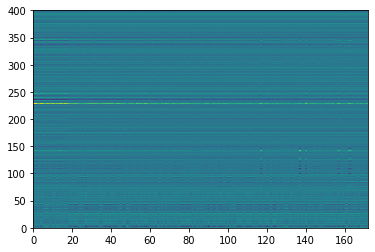

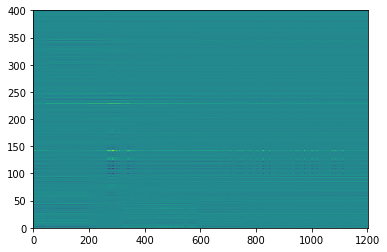

In [28]:
pplot.pcolor(np.mean(z0,1).T)
pplot.show()
pplot.pcolor(np.mean(z1,1).T)


In [23]:
inspect_ddout = Model(inputs = model.get_layer("timeseries_input").input,outputs = model.get_layer("DN_DN1_Out").output)
#inspect_ddout.predict()

In [63]:
#np.sum(y_train < 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 2559, 2)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 2559, 50)     150         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 2559, 50)     15100       DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 2559, 50)     15100       DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]             

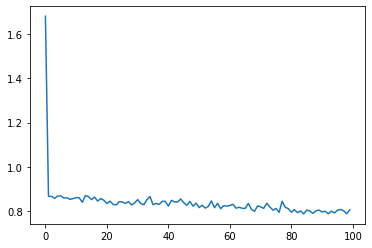

In [57]:
pplot.plot(history_d.history['val_Y_output_loss'])
#pplot.plot(history_d.history['loss'])
#pplot.savefig("asdf.png")


asdf.png
